In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 12 18:05:52 2018

@author: xz556
"""
import pandas as pd
import numpy as np
# import xgboost as xgb
# from NewPredictionModel_AllFeature import predictionModel
from NewPredictionModel_AllFeature import attribute_density
from NewPredictionModel_AllFeature import data_input, attribute_range, relationship_range
from NewPredictionModel_AllFeature import cost_sampled
from scipy.optimize import brute
from scipy import optimize
import timeit
import matplotlib.pylab as plt
from itertools import product
# import pickle
from sklearn.model_selection import train_test_split
from logistic_regression import coef
from logistic_regression import my_cols
import sys  # Need to have acces to sys.stdout
from matplotlib.ticker import PercentFormatter
from matplotlib import colors


def ratio(ele):
    return ele[0]


coef[0] = - np.abs(coef[0]*25)
coef = coef/10
coef[0] = coef[0]*10
coef[29] = 8.7 + 6 + 8*0.7
coef[28] = 6.7 + 6 + 8*0.7
coef[27] = 0.8 + 6 + 8*0.7
coef[26] = - 2.2 + 6 + 8*0.7
coef[25] = - 4.2 + 6 + 8*0.7
for i in range(1, 24):
	coef[i] = coef[i]*20

print(coef)

RelCus_W = np.array([[0.258333333333333, 0.483333333333333, 0.125, 0.0833333333333334, 0.05],
                    [0., 0.483333333333333, 0.25, 0.166666666666667, 0.1],
                    [0, 0.00833333333333378, 0.591666666666666, 0.25,0.15],
                    [0, 0., 0.0666666666666668, 0.683333333333333, 0.25],
                    [0, 0, 0, 0, 1]])
RelCus_L = np.array([[1, 0, 0, 0, 0],
                    [0.258333333333333, 0.483333333333333, 0.125, 0.0833333333333334, 0.05],
                    [0, 0.266666666666667, 0.466666666666666, 0.166666666666667, 0.1],
                    [0, 0., 0.2, 0.6, 0.2],
                    [0, 0, 0.025, 0.025, 0.95]])
print(RelCus_L.shape, np.sum(RelCus_L, axis=1))
print(RelCus_W.shape, np.sum(RelCus_W, axis=1))
# return winning probability
# input: price, relaitionship, att is tuple of iid deal attributes
def pred(p, relaitionship, *att):
    dim = len(attribute_range)
    l = np.array([p])
    #print(type(att))
    for i in range(dim):
        vec = np.zeros(attribute_range[i] + 1)
        #print(vec)
        vec[att[i]] = 1.
        l = np.append(l, vec)
    vec = np.zeros(relationship_range + 1)
    vec[relaitionship] = 1.0
    l = np.append(l, vec)
    #print(l)
    return 1./(1. + np.exp(-np.dot(l, coef)))


# return expected loss in current deal
# input: price, para is tuple of iid deal attributes + relationship + cost
def expected_loss(p, *para):
    *att,relationship, cost = para
    return -(p - cost)*pred(p, relationship, *att)

def total_loss(p, *para):
    *att, relationship, cost, V, gamma, RelCus_W, RelCus_L = para
    winning_probability = pred(p, relationship, *att)
    future_loss = - gamma*(winning_probability*np.dot(RelCus_W[relationship], V)+(1-winning_probability)*np.dot(RelCus_L[relationship], V))
    return expected_loss(p, *att, relationship, cost) + future_loss
# total_loss(1, 0,0,0,0, 0, 0.5, np.array([0.,0.,0.,0.,0.]), 0.9, RelCus_W, RelCus_L)

def updateValue(V, W, gamma, Rel_W = RelCus_W, Rel_L = RelCus_L, costSample = 1, lower = 0.8, upper = 1.5):
    MV = np.array([0.,0.,0.,0.,0.])
    expectationV = np.array([0.,0.,0.,0.,0.])
    expectationW = np.array([0.,0.,0.,0.,0.])
    priceV = np.array([0.,0.,0.,0.,0.])
    priceW = np.array([0.,0.,0.,0.,0.])
    iterator = tuple([range(i+1) for i in attribute_range])
    for att in product(*iterator):
        for q in range(costSample):
            value = cost_sampled(0)
            for relationship in range(relationship_range + 1):
                #cost = value
                #para_opt = (*att, relationship, cost, V, gamma, Rel_W, Rel_L)
                #para_myo = (*att, relationship, cost)
                #rranges = ((0.8*cost, 1.5*cost),)
                #res_opt = brute(total_loss, rranges, args = para_opt, Ns = 150, full_output=True, finish=None)
                #res_myo = brute(total_loss, rranges, args = para_myo, Ns = 150, full_output=True, finish=None)
                cost = value
                
                para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
                para_myo = (*att, relationship, cost, MV, gamma, RelCus_W, RelCus_L)
                rranges = ((lower*cost, upper*cost),)
                res_opt = brute(total_loss, rranges, args = para_opt, Ns = 75, full_output=True, finish=None)
                res_myo = brute(total_loss, rranges, args = para_myo, Ns = 75, full_output=True, finish=None)
                density_list = []
                for i in range(len(attribute_range)):
                    density_list.append(attribute_density[i][att[i]])
                #optimalP[relationship] = optimalP[relationship] + res_opt[0]*np.prod(np.array(density_list))/costSample
                #myopicP[relationship] = myopicP[relationship] + res_myo[0]*np.prod(np.array(density_list))/costSample
                
                density_list = []
                for i in range(len(attribute_range)):
                    density_list.append(attribute_density[i][att[i]])
                priceV[relationship] = priceV[relationship] + res_opt[0]*np.prod(np.array(density_list))/costSample
                priceW[relationship] = priceW[relationship] + res_myo[0]*np.prod(np.array(density_list))/costSample
                expectationV[relationship] = expectationV[relationship] + (-total_loss(res_opt[0], *para_opt))*np.prod(np.array(density_list))/costSample
                expectationW[relationship] = expectationW[relationship] + (-total_loss(res_myo[0], *para_opt))*np.prod(np.array(density_list))/costSample
    return (expectationV, expectationW, priceV, priceW)

def BellmanMap(V, MV, gamma, Rel_W = RelCus_W, Rel_L = RelCus_L, learning_rate = 0.1, lower = 0.8, upper = 1.5):
    W, MW, priceV, priceMV = updateValue(V, MV, gamma, Rel_W, Rel_L, lower = lower, upper = upper)
    # print(W)
    U = (1. - learning_rate)*V + learning_rate*W
    MU = (1. - learning_rate)*MV + learning_rate*MW
    return (U, MU, priceV, priceMV)
#V = np.array([1.,1.,1.,1.,1.])
#BellmanMap(V, 0.9, RelCus_W, RelCus_L, 1)

def Iteration(gamma, T, step_size = 10, epsilon = 0.01):
    V = np.array([0.,0.,0.,0.,0.])
    MV = np.array([0.,0.,0.,0.,0.])
    start = timeit.default_timer()
    iteration = 0
    for t in range(T):
        U, MU, priceO, priceM = BellmanMap(V, MV, gamma, RelCus_W, RelCus_L, step_size/(step_size + iteration))
        
        stop = timeit.default_timer()
        print(f"Gamma: {gamma}, t: {t}")
        print("Optimal Profit")
        print(U)
        print("Myopic Profit")
        print(MU)
        print("Increased Margin")
        print((U/MU - 1)*100)
        print("Optimal Price")
        print(priceO)
        print("Myopic Price")
        print(priceM)
        print("Discount")
        print((1 - priceO/priceM)*100)
        print(stop - start)
        print("")
        
        V, MV = U, MU
    return (V, MV)

def plotValueFunction(V):
    plt.plot(V,'o-')
    plt.ylabel("Value Function")
    plt.xlabel('Client Relationship')
    return

def Price(V, gamma, costSample = 1, lower = 0.8, upper = 1.5):
    myopicP = np.zeros(relationship_range + 1)
    optimalP = np.zeros(relationship_range + 1)
    price_list = list()
    W = np.array([0.,0.,0.,0.,0.])
    iterator = tuple([range(i+1) for i in attribute_range])
    for att in product(*iterator):
        for q in range(costSample):
            value = cost_sampled(0)
            for relationship in range(relationship_range + 1):
                cost = value
                #cost = value*(0.8 + (1 - (relationship+0.0)/relationship_range)* 0.1)
                para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
                para_myo = (*att, relationship, cost, W, gamma, RelCus_W, RelCus_L)
                rranges = ((lower*cost, upper*cost),)
                res_opt = brute(total_loss, rranges, args = para_opt, Ns = 75, full_output=True, finish=None)
                res_myo = brute(total_loss, rranges, args = para_myo, Ns = 75, full_output=True, finish=None)
                density_list = []
                for i in range(len(attribute_range)):
                    density_list.append(attribute_density[i][att[i]])
                optimalP[relationship] = optimalP[relationship] + res_opt[0]*np.prod(np.array(density_list))/costSample
                myopicP[relationship] = myopicP[relationship] + res_myo[0]*np.prod(np.array(density_list))/costSample
                entry = [(1-res_opt[0]/res_myo[0])*100, res_myo[0], res_opt[0], *att, relationship, cost]
                # print(entry[0])
                price_list.append(entry)
    #price_list.sort(key = ratio)
    return (myopicP, optimalP, price_list)

def plotPrice(myopicP, optimalP):
    plt.plot(myopicP, 'k^:', color='b', label='Myopic Price')
    plt.plot(optimalP, 'k^:', color='r', label='Optimal Price')
    plt.ylabel("Price ($M)")
    plt.xlabel('Firm-Customer Relationship')
    plt.legend(bbox_to_anchor=(1, 0), loc=4, borderaxespad=0., fontsize = 8)
    plt.savefig("provider_client_relationship.png")
    # plt.title("Myopic Price versus Optimal Price")
    return



def cost_price_plot(V, gamma, lower = 0.8, upper = 1.5):
    costs = np.arange(10, 30, 5)
    price = np.zeros((5, len(costs)))
    #att = (0,0,0,0)
    iterator = tuple([range(i+1) for i in attribute_range])
    for att in product(*iterator):
        for relationship in range(5):
            for i in range(len(costs)):
                cost = costs[i]
                para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
                rranges = ((lower*cost, upper*cost),)
                res_opt = brute(total_loss, rranges, args = para_opt, Ns = 75, full_output=True, finish=None)
                density_list = []
                for j in range(len(attribute_range)):
                    density_list.append(attribute_density[j][att[j]])
                price[relationship, i] += res_opt[0] * np.prod(np.array(density_list))
    print(price)
    fig, ax = plt.subplots()
    plt.plot([0,1,2,3,4], np.array(price[:, 0]), 'k^:', color = 'b', label = 'cost = 10 M')
    plt.plot([0,1,2,3,4], np.array(price[:, 1]), 'k^:', color = 'r', label = 'cost = 15 M')
    plt.plot([0,1,2,3,4], np.array(price[:, 2]), 'k^:', color = 'y', label = 'cost = 20 M')
    plt.plot([0,1,2,3,4], np.array(price[:, 3]), 'k^:', color = 'g', label = 'cost = 25 M')
    
    ax.set_xticks(range(5))
    plt.xlabel("Firm-Customer Relationship")
    plt.ylabel("Optimal Price ($M)")
    plt.legend(bbox_to_anchor=(1.0, 0), loc=4, borderaxespad=0., fontsize = 8)
    plt.savefig("price_depending_on_cost.png")
    plt.show()
            
            
def deal_attribute_difference(V, gamma, deal_attribute, costSample = 20):
    opt = np.zeros((4, 5))
    for q in range(costSample):
        value = cost_sampled(0)
        for index in range(4):
            att = deal_attribute[index]
            for relationship in range(relationship_range + 1):
                cost = value
                para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
                rranges = ((0.8*cost, 1.5*cost),)
                res_opt = brute(total_loss, rranges, args = para_opt, Ns = 600, full_output=True, finish=None)
                opt[index][relationship] = opt[index][relationship] + res_opt[0]
    opt = opt/costSample
    return opt

def plotWinningProbabilityCurve(deal_list, plotRange):
    low, high = plotRange;
    x = np.arange(low, high, (high - low)/1000.0)
    #print(x)
    y0 = np.zeros(x.size)
    y1 = np.zeros(x.size)
    y2 = np.zeros(x.size)
    y3 = np.zeros(x.size)
    for i in range(x.size):
        y0[i] = pred(x[i], 0, *deal_list[0])
        y1[i] = pred(x[i], 0, *deal_list[1])
        y2[i] = pred(x[i], 0, *deal_list[2])
        y3[i] = pred(x[i], 0, *deal_list[3])
    plt.plot(x, y0, color = 'b', label = 'Deal 1(Hardest-to-Wim)')
    plt.plot(x, y1, color = 'r', label = 'Deal 2')
    plt.plot(x, y2, color = 'y', label = 'Deal 3')
    plt.plot(x, y3, color = 'g', label = 'Deal 4(Easiest-to-Win)')
    plt.xlabel("Price ($M)")
    plt.ylabel("Winning Probability")
    plt.legend(bbox_to_anchor=(1, 0), loc=4, borderaxespad=0., fontsize = 8)
    plt.title("Winning Probability Sensitivity")
    plt.savefig("deal_attribute_probability.png")
    plt.show()


def attribute_price_plot(V):
    deal_list = [[0, 6, 2, 7],
                 [0, 0, 1, 1],
                 [1, 4, 4, 4],
                 [1, 7, 4, 8]]
    price = deal_attribute_difference(V, 0.9, deal_list)
    fig, ax = plt.subplots()
    plt.plot([0,1,2,3,4], price[0], 'k^:', color = 'b', label = 'Deal 1(Hardest-to-Win)')
    plt.plot([0,1,2,3,4], price[1], 'k^:', color = 'r', label = 'Deal 2')
    plt.plot([0,1,2,3,4], price[2], 'k^:', color = 'y', label = 'Deal 3')
    plt.plot([0,1,2,3,4], price[3], 'k^:', color = 'g', label = 'Deal 4(Easiest-to-Win)')
    plt.xlabel("Firm-Customer Relationship")
    plt.ylabel("Price ($M)")
    plt.title("Price Depending on Deal Attribute")
    ax.set_xticks(range(5))
    plt.legend(bbox_to_anchor=(1.0, 0), loc=4, borderaxespad=0., fontsize = 8)
    plt.savefig("deal_attribute_price.png")
    plt.show()
    plotWinningProbabilityCurve(deal_list, (0, 25))

def myo_opt(V, gamma, FILE_NAME):
    W = np.zeros(5);
    data=pd.read_excel(FILE_NAME,index_col=False)
    opt_list = []
    myo_list = []
    discount = []
    num = data.shape[0]
    for i in range(int(num/20)):
        att = (int(data.iloc[i][0]), int(data.iloc[i][1]), int(data.iloc[i][2]), int(data.iloc[i][3]))
        relationship = int(data.iloc[i][4])
        cost = data.iloc[i][5]*5
        para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
        para_myo = (*att, relationship, cost, W, gamma, RelCus_W, RelCus_L)
        rranges = ((0.0, 10*cost),)
        res_opt = brute(total_loss, rranges, args = para_opt, Ns = 150, full_output=True, finish=None)
        res_myo = brute(total_loss, rranges, args = para_myo, Ns = 150, full_output=True, finish=None)
        opt_list.append(res_opt[0]);
        myo_list.append(res_myo[0]);
        discount.append((1 - res_opt[0]/res_myo[0])*100)
    discount = np.array(discount)
    n_bin = [0, 10, 20, 30, 40, 50]
    fig, ax = plt.subplots()
    # plt.hist(discount, bins = n_bin, normed = True)
    plt.xlabel("Discount(%)")
    plt.ylabel("Percentage")
    plt.title("Discount Histogram")
    ax.set_xticks(range(0, 60, 10))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1))
    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = ax.hist(discount, bins=n_bin, density = True)
        
    # We'll color code by height, but you could use any scalar
    fracs = [0.2, 0.4, 0.6, 0.8, 1.0]
            
    # we need to normalize the data to 0..1 for the full range of the colormap
    # norm = colors.Normalize(fracs.min(), fracs.max())
    
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(thisfrac)
        thispatch.set_facecolor(color)
        
        #plt.xlabel("Deal ID")
        #plt.ylabel("Discount")
    plt.savefig("myo_opt.png")
    plt.show()
    return


Value (M$):0.022762910942355073
Country of the Client_0:-0.030496910308864384
Country of the Client_1:0.0369018716719647
Industrial Sector of the Client_0:-0.21883149631475463
Industrial Sector of the Client_1:-0.05548396625823553
Industrial Sector of the Client_2:0.04930409333075294
Industrial Sector of the Client_3:-0.023308674363252263
Industrial Sector of the Client_4:0.028118689644747123
Industrial Sector of the Client_5:0.13144448792893007
Industrial Sector of the Client_6:-0.438989884031285
Industrial Sector of the Client_7:0.5341517114261994
How was the Deal Identified_0:-0.08666897667746068
How was the Deal Identified_1:0.15921746311400617
How was the Deal Identified_2:-0.19324440704935955
How was the Deal Identified_3:-0.1725330653473882
How was the Deal Identified_4:0.29963394732329146
Type of the Client_0:0.16771658697233566
Type of the Client_1:-0.15141172272836084
Type of the Client_2:0.005788832478633611
Type of the Client_3:0.2264344924290631
Type of the Client_4:0.3260

In [3]:
from multiprocessing import Process

T = 20
def optimal_price(gamma, T, res):
    V, _ = Iteration(gamma, T)
    _, opt_p, __ = Price(V, gamma)
    res.append(opt_p)
    print(f"optimal price (gamma = {gamma}): {opt_p}")
    return

def package(gamma, T):
    V, _ = Iteration(gamma, T)
    cost_price_plot(V, gamma, lower=0.8, upper=1.5)
    myo_opt(V, gamma, "Input_df_4.xlsx")
    attribute_price_plot(V)
    _, opt_p, myo_p = Price(V, gamma)
    plotPrice(myo, opt)

if __name__ == "__main__":
    p1 = Process(target=package, args=(0.9, 20))
    p1.start()

    
    process = []
    prices = []
    for gamma in [0.0, 0.2, 0.4, 0.9]:
        p = Process(target=optimal_price, args=(gamma, T, prices))
        p.start()
        process.append(p)

    p1.join()
    for p in process:
        p.join()
    print(prices)


Gamma: 0.2, t: 0
Optimal Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Myopic Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Increased Margin
[0. 0. 0. 0. 0.]
Optimal Price
[18.38126481 18.72697215 20.60822672 24.54213187 24.77680993]
Myopic Price
[18.38126481 18.72697215 20.60822672 24.54213187 24.77680993]
Discount
[0. 0. 0. 0. 0.]
99.28150386735797
0

Gamma: 0.9, t: 0
Optimal Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Myopic Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Increased Margin
[0. 0. 0. 0. 0.]
Optimal Price
[18.38126481 18.72697215 20.60822672 24.54213187 24.77680993]
Myopic Price
[18.38126481 18.72697215 20.60822672 24.54213187 24.77680993]
Discount
[0. 0. 0. 0. 0.]
99.89806292951107
0

Gamma: 0.4, t: 0
Optimal Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Myopic Profit
[0.07789931 0.42155902 2.30774536 7.60694784 8.06100821]
Increased Margin
[0. 0. 0. 0. 0.]
Optimal Price
[18.3812

Myopic Price
[18.35135781 18.69626534 20.57318903 24.58488722 24.7410254 ]
Discount
[0. 0. 0. 0. 0.]
402.65737668052316
0

Gamma: 0.4, t: 3
Optimal Profit
[ 0.20829887  1.7845214   5.00432695 12.21161472 13.157068  ]
Myopic Profit
[ 0.19347393  1.76200891  4.98975413 12.21133335 13.15706794]
Increased Margin
[7.66250050e+00 1.27766006e+00 2.92054879e-01 2.30418149e-03
 4.51865212e-07]
Optimal Price
[17.28448857 18.01227314 20.26315117 24.5745893  24.74060425]
Myopic Price
[18.35135781 18.69626534 20.57318903 24.58488722 24.7410254 ]
Discount
[5.81357113e+00 3.65844298e+00 1.50699956e+00 4.18871863e-02
 1.70223484e-03]
404.013871666044
0

Gamma: 0.2, t: 3
Optimal Profit
[ 0.11741441  0.90553919  3.31743781  9.46450084 10.11229334]
Myopic Profit
[ 0.1156579   0.90226263  3.3149958   9.46442709 10.11229334]
Increased Margin
[1.51871286e+00 3.63149774e-01 7.36655254e-02 7.79215087e-04
 0.00000000e+00]
Optimal Price
[17.97751035 18.42778213 20.44319197 24.57617922 24.7410254 ]
Myopic Price


Increased Margin
[8.70143146e+00 1.44195438e+00 2.90659129e-01 8.53942718e-04
 1.68856772e-05]
Optimal Price
[16.88308747 17.70972624 20.1104019  24.19252422 24.33411901]
Myopic Price
[18.06723916 18.44165658 20.4298189  24.19896468 24.33453416]
Discount
[6.55413748e+00 3.96889691e+00 1.56348425e+00 2.66145715e-02
 1.70600055e-03]
709.7925155162811
0

Gamma: 0.9, t: 7
Optimal Profit
[ 8.47433953 19.15334735 29.25885451 42.56140214 45.9716096 ]
Myopic Profit
[ 6.2676322  17.82244108 28.86903636 42.55936865 45.97158976]
Increased Margin
[3.52079902e+01 7.46758690e+00 1.35029842e+00 4.77801305e-03
 4.31582170e-05]
Optimal Price
[13.2004308  14.8646603  19.13203106 24.55697625 24.72088437]
Myopic Price
[18.32706382 18.66284765 20.55372203 24.58254483 24.72257183]
Discount
[2.79730189e+01 2.03515959e+01 6.91695144e+00 1.04011121e-01
 6.82557688e-03]
790.9142117165029
0

Gamma: 0.9, t: 7
Optimal Profit
[ 8.47433953 19.15334735 29.25885451 42.56140214 45.9716096 ]
Myopic Profit
[ 6.2676322  1

Discount
[2.80276976e+01 2.17980644e+01 7.36016434e+00 1.37738971e-01
 2.08183038e-02]
1088.5786268115044
0

Gamma: 0.9, t: 10
Optimal Profit
[14.83025012 27.06081148 37.92520854 51.65271329 55.40211685]
Myopic Profit
[12.03102716 25.35904847 37.4814527  51.64956201 55.40194121]
Increased Margin
[2.32666997e+01 6.71067378e+00 1.18393446e+00 6.10126969e-03
 3.17033327e-04]
Optimal Price
[13.15018432 14.56809278 19.02444257 24.39041832 24.59952123]
Myopic Price
[18.2711736  18.62881356 20.53592004 24.42405977 24.6046435 ]
Discount
[2.80276976e+01 2.17980644e+01 7.36016434e+00 1.37738971e-01
 2.08183038e-02]
1095.5815713442862
0

Gamma: 0.4, t: 10
Optimal Profit
[ 0.24998445  1.99333006  5.37121808 12.5816795  13.43189563]
Myopic Profit
[ 0.2304078   1.96465795  5.35541332 12.581538   13.43188173]
Increased Margin
[8.49652243e+00 1.45939466e+00 2.95117351e-01 1.12473307e-03
 1.03497065e-04]
Optimal Price
[17.06775037 17.8773821  20.21511039 24.41150431 24.5996171 ]
Myopic Price
[18.271173

Increased Margin
[8.48100215e+00 1.37599641e+00 3.12888714e-01 6.36928272e-04
 2.01009631e-07]
Optimal Price
[17.15364548 17.96851511 20.2541782  24.59841457 24.77894782]
Myopic Price
[18.37298396 18.70584227 20.58749951 24.60525071 24.77895628]
Discount
[6.63658378e+00 3.94169453e+00 1.61904710e+00 2.77832733e-02
 3.41692762e-05]
1406.1454408504069
0

Gamma: 0.0, t: 13
Optimal Profit
[0.07773138 0.42094625 2.30290265 7.66886894 8.11253214]
Myopic Profit
[0.07773138 0.42094625 2.30290265 7.66886894 8.11253214]
Increased Margin
[0. 0. 0. 0. 0.]
Optimal Price
[18.37298396 18.70584227 20.58749951 24.60525071 24.77895628]
Myopic Price
[18.37298396 18.70584227 20.58749951 24.60525071 24.77895628]
Discount
[0. 0. 0. 0. 0.]
1411.433804858476
0

Gamma: 0.2, t: 13
Optimal Profit
[ 0.12154531  0.92763896  3.3538945   9.51194181 10.1219885 ]
Myopic Profit
[ 0.11962137  0.92417159  3.35120981  9.51193863 10.1219885 ]
Increased Margin
[1.60835914e+00 3.75186697e-01 8.01109992e-02 3.34438060e-05
 0.

0

Gamma: 0.2, t: 16
Optimal Profit
[ 0.12227777  0.92717367  3.35292222  9.52820367 10.12372621]
Myopic Profit
[ 0.12039228  0.92375043  3.35013594  9.5281578  10.12372621]
Increased Margin
[1.56611912e+00 3.70580880e-01 8.31691085e-02 4.81419054e-04
 0.00000000e+00]
Optimal Price
[17.94761794 18.4130536  20.43996261 24.62687232 24.75049345]
Myopic Price
[18.3521806  18.69218061 20.57365918 24.63085978 24.75049345]
Discount
[2.2044392  1.49328221 0.64984341 0.01618885 0.        ]
1714.4656480066478
0

Gamma: 0.9, t: 17
Optimal Profit
[26.26582444 39.380433   50.60631208 64.52183416 68.50967437]
Myopic Profit
[23.17714963 37.51278038 50.13132463 64.51838597 68.5096354 ]
Increased Margin
[1.33263791e+01 4.97871021e+00 9.47486338e-01 5.34450392e-03
 5.68854558e-05]
Optimal Price
[13.22448027 14.50294182 19.02632972 24.49051556 24.72850785]
Myopic Price
[18.37059465 18.71104601 20.59672338 24.53040281 24.73022829]
Discount
[2.80127806e+01 2.24899462e+01 7.62448293e+00 1.62603308e-01
 6.95

Process Process-1:
Traceback (most recent call last):
  File "/home/xz556/.conda/envs/xz_vm/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xz556/.conda/envs/xz_vm/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-8db5f6951cca>", line 13, in package
    cost_price_plot(V, gamma, lower=0.8, upper=1.5)
  File "<ipython-input-1-0ebf70d24d70>", line 222, in cost_price_plot
    res_opt = brute(total_loss, rranges, args = para_opt, Ns = 75, full_output=True, finish=None)
  File "/home/xz556/.conda/envs/xz_vm/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 2927, in brute
    Jout = np.array(list(mapper(wrapped_func, grid)))
  File "/home/xz556/.conda/envs/xz_vm/lib/python3.6/site-packages/scipy/optimize/optimize.py", line 2998, in __call__
    return self.f(np.asarray(x).flatten(), *self.args)
  File "<ipython-input-1-0ebf70d24d70>", line 84, in total_l

Gamma: 0.9, t: 19
Optimal Profit
[28.40175014 41.57888331 52.84914868 66.78655651 70.77531398]
Myopic Profit
[25.2375414  39.63972028 52.37154386 66.7842263  70.77529264]
Increased Margin
[1.25377060e+01 4.89196953e+00 9.11954832e-01 3.48916413e-03
 3.01582556e-05]
Optimal Price
[13.06774556 14.34560247 18.9377352  24.37135306 24.49072099]
Myopic Price
[18.17954607 18.51807773 20.45965524 24.39592118 24.49183266]
Discount
[2.81184167e+01 2.25319027e+01 7.43863974e+00 1.00705816e-01
 4.53894495e-03]
1994.5359130203724
0

Gamma: 0.4, t: 19
Optimal Profit
[ 0.25152981  1.98190665  5.36150519 12.6064726  13.43119851]
Myopic Profit
[ 0.23208917  1.95450751  5.34570047 12.60629219 13.43119831]
Increased Margin
[8.37636449e+00 1.40184373e+00 2.95653024e-01 1.43107892e-03
 1.47382895e-06]
Optimal Price
[16.98496992 17.79720908 20.14105929 24.38868049 24.49178832]
Myopic Price
[18.17954607 18.51807773 20.45965524 24.39592118 24.49183266]
Discount
[6.57098998e+00 3.89278340e+00 1.55719121e+00 2.

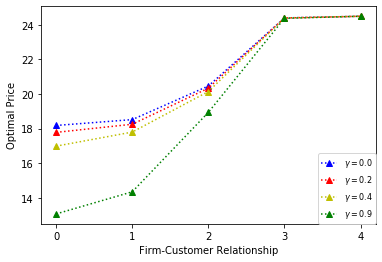

In [4]:
# T = 20
prices = {}
prices[0.0] = [18.17954607, 18.51807773, 20.45965524, 24.39592118, 24.49183266]
prices[0.2] = [17.78055916, 18.2501934,  20.33493682, 24.39119501, 24.49180569]
prices[0.4] = [16.98496992, 17.79720908, 20.14105929, 24.38868049, 24.49178832]
prices[0.9] = [13.06774556, 14.34560247, 18.9377352,  24.37135306, 24.49072099]

fig, ax = plt.subplots()
plt.plot(prices[0.0], "k:^", color="b", label=r'$\gamma=0.0$')
plt.plot(prices[0.2], "k:^", color="r", label=r'$\gamma=0.2$')
plt.plot(prices[0.4], "k:^", color="y", label=r'$\gamma=0.4$')
plt.plot(prices[0.9], "k:^", color="g", label=r'$\gamma=0.9$')
ax.set_xticks(range(0, 5))
plt.xlabel("Firm-Customer Relationship")
plt.ylabel("Optimal Price")
plt.legend(bbox_to_anchor=(1.0, 0), loc=4, borderaxespad=0., fontsize = 8)
plt.savefig("gamma")
plt.show()


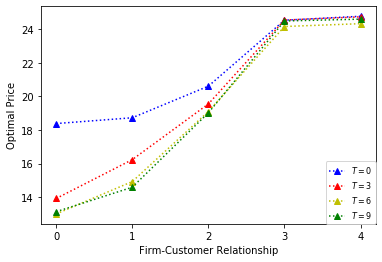

In [5]:
# gamma = 0.9
prices = {}
prices[0] = [18.38126481, 18.72697215, 20.60822672, 24.54213187, 24.77680993]
prices[3] = [13.9157486,  16.23093892, 19.54920831, 24.54951165, 24.73996595]
prices[6] = [12.99695416, 14.92460065, 19.09716983, 24.1655147,  24.33386377]
prices[9] = [13.12868556, 14.58689815, 19.02146267, 24.49443426, 24.60382298]

fig, ax = plt.subplots()
plt.plot(prices[0], "k:^", color="b", label=r'$T=0$')
plt.plot(prices[3], "k:^", color="r", label=r'$T=3$')
plt.plot(prices[6], "k:^", color="y", label=r'$T=6$')
plt.plot(prices[9], "k:^", color="g", label=r'$T=9$')
ax.set_xticks(range(0, 5))
plt.xlabel("Firm-Customer Relationship")
plt.ylabel("Optimal Price")
plt.legend(bbox_to_anchor=(1.0, 0), loc=4, borderaxespad=0., fontsize = 8)
plt.savefig("planning_horizon")
plt.show()

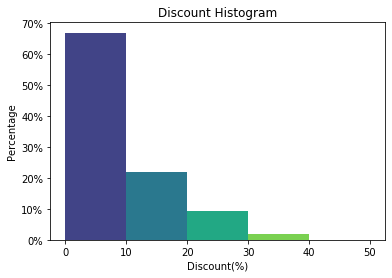

[[ 8.99816616 12.00667468 16.         20.        ]
 [12.77129043 13.8742054  16.16043966 20.00133438]
 [15.         18.58272165 20.07941755 22.89649758]
 [15.         22.5        28.3824964  29.52545895]
 [15.         22.5        29.99030177 32.47177627]]


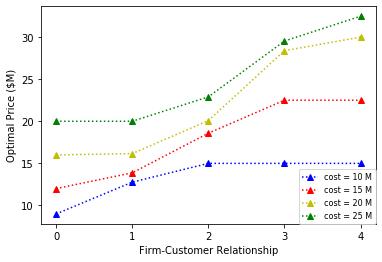

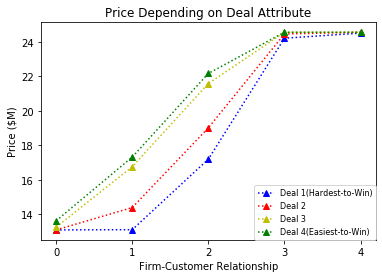

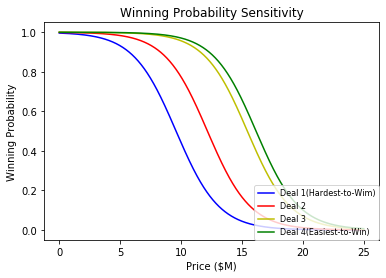

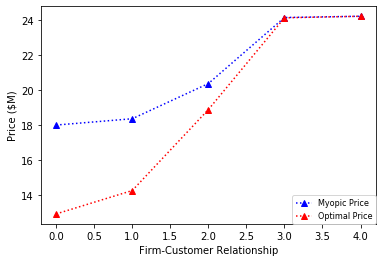

In [15]:

def myo_opt(V, gamma, FILE_NAME):
    W = np.zeros(5);
    data=pd.read_excel(FILE_NAME,index_col=False)
    opt_list = []
    myo_list = []
    discount = []
    num = data.shape[0]
    for i in range(int(num/20)):
        att = (int(data.iloc[i][0]), int(data.iloc[i][1]), int(data.iloc[i][2]), int(data.iloc[i][3]))
        relationship = int(data.iloc[i][4])
        cost = data.iloc[i][5]*5
        para_opt = (*att, relationship, cost, V, gamma, RelCus_W, RelCus_L)
        para_myo = (*att, relationship, cost, W, gamma, RelCus_W, RelCus_L)
        rranges = ((0.0, 10*cost),)
        res_opt = brute(total_loss, rranges, args = para_opt, Ns = 150, full_output=True, finish=None)
        res_myo = brute(total_loss, rranges, args = para_myo, Ns = 150, full_output=True, finish=None)
        opt_list.append(res_opt[0]);
        myo_list.append(res_myo[0]);
        discount.append((1 - res_opt[0]/res_myo[0])*100)
    discount = np.array(discount)
    n_bin = [0, 10, 20, 30, 40, 50]
    fig, ax = plt.subplots()
    # plt.hist(discount, bins = n_bin, normed = True)
    plt.xlabel("Discount(%)")
    plt.ylabel("Percentage")
    plt.title("Discount Histogram")
    ax.set_xticks(range(0, 60, 10))
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1))
    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = ax.hist(discount, bins=n_bin, density = True)
        
    # We'll color code by height, but you could use any scalar
    fracs = [0.2, 0.4, 0.6, 0.8, 1.0]
            
    # we need to normalize the data to 0..1 for the full range of the colormap
    # norm = colors.Normalize(fracs.min(), fracs.max())
    
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(thisfrac)
        thispatch.set_facecolor(color)
        
        #plt.xlabel("Deal ID")
        #plt.ylabel("Discount")
    plt.savefig("myo_opt.png")
    plt.show()
    return

# MV = [25.2375414  39.63972028 52.37154386 66.7842263  70.77529264]
V = [28.40175014, 41.57888331, 52.84914868, 66.78655651, 70.77531398]
myo_opt(V, gamma, "Input_df_4.xlsx")
cost_price_plot(V, gamma, lower=0.8, upper=1.5)
attribute_price_plot(V)
myo_p, opt_p, _ = Price(V, gamma)
plotPrice(myo_p, opt_p)